# **EDA**

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("task1.csv")

In [5]:
df.head(3)

,id,unique_id,inserttime,start_datetime,end_datetime,alert_priority,finding_arn,alert_starttime,description,account_id,...,machine_arch,machine_isexternal,machine_internetexposure,machine_name,fileexepath_lastseentime,fileexepath_firstseentime,instancename,internal_categorization,source_entity,target_entity
0,19434,218176,2024-07-14 17:47:40,1720494000,1720497600,NaN,NaN,1720494000,AWS Account 274059328831 : lacework-global-12...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Defense Evasion,identity,NaN
1,19435,218174,2024-07-14 17:47:40,1720494000,1720497600,NaN,NaN,1720494000,AWS Account 822165131996 : lacework-global-12...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Defense Evasion,identity,NaN
2,21971,219490,2024-07-14 23:23:03,1720717200,1720720800,NaN,NaN,1720717200,For account: 280566572992 : Route-table/route...,7.973821e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Defense Evasion,identity,network connection


>  Their are 174 columns in dataset

In [6]:
df.columns

Index(['id', 'unique_id', 'inserttime', 'start_datetime', 'end_datetime',
       'alert_priority', 'finding_arn', 'alert_starttime', 'description',
       'account_id',
       ...
       'machine_arch', 'machine_isexternal', 'machine_internetexposure',
       'machine_name', 'fileexepath_lastseentime', 'fileexepath_firstseentime',
       'instancename', 'internal_categorization', 'source_entity',
       'target_entity'],
      dtype='object', length=174)

In [7]:
time_columns = [
    'inserttime',
    'start_datetime',
    'end_datetime',
    'alert_starttime',
    'instance_launch_time',
    'alert_updatedtime',
    'ipaddress_endtime',
    'ipaddress_ipaddress',
    'user_endtime',
    'rawtime_endtime',
    'rawtime_lasttime',
    'rawtime_firsttime',
    'sourceipaddress_endtime',
    'sourceipaddress_ipaddress',
    'api_timestamps',
    'user_timestamps',
    'rawtime_timestamps',
    'elbv2_created_time',
    'ec2_volume_create_time',
    'ec2_volume_attach_time',
    'fileexepath_lastseentime',
    'fileexepath_firstseentime'
]

In [8]:
required_columns = [col for col in df.columns if "time"not in col.lower()]
required_columns = [col for col in required_columns if "bytes"not in col.lower()]

distinct_items = {}

for col in required_columns:
    distinct_items[col] = df[col].unique()

In [9]:
distinct_items

{'id': array([19434, 19435, 21971, ...,  2180,  2188,  2164]),
 'unique_id': array([218176, 218174, 219490, ..., 217720, 217788, 217609]),
 'alert_priority': array([nan, 'Low', 'Medium'], dtype=object),
 'finding_arn': array([nan]),
 'description': array(['AWS Account 274059328831  : lacework-global-128 EC2 instances should not have a Public IP address attached',
        'AWS Account 822165131996  : lacework-global-121 Identity and Access Management (IAM) user should not be inactive for more than 30 days',
        'For account: 280566572992  : Route-table/route modified 4 times  by user  AROA3TJ5NA2LCFLZWY63B:penfed-prod-SC2-Lambda',
        ...,
        'For account: 286862168236 (and 21 more)  (acmesecurityops) : Unauthorized API call was attempted 3862 times  by user  AROAVLWBCDV6BF26KDDR6:i-0a24878be2f8b1951   (and 553 more)',
        'Bad external IP 199.45.155.70  connected to one or more internal hosts. This event typically indicates that an IP address associated with various at

# **Base Model**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json
import csv
from collections import defaultdict

# New imports for LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Load the data
df = pd.read_csv('task1.csv').head(2000)
test_df = pd.read_csv('task1.csv').tail(83)

# Function to classify use case
def classify_use_case(row):
    categories = []
    if 'IAM' in row['alert_name'] or 'Role' in row['alert_name'] or 'Policy' in row['alert_name']:
        categories.append('IAM / Entitlement Issues')
    if 'New violations' in row['alert_name'] or 'Compliance' in row['alert_name'] or 'Failed' in row['alert_name']:
        categories.append('Compliance / Hygiene / Security Issues / API failures')
    if 'Vulnerability' in row['alert_name']:
        categories.append('Vulnerability Management')
    if 'Malicious' in row['alert_name'] or 'Threat' in row['alert_name']:
        categories.append('Known Malicious Artifacts')
    if 'Key' in row['alert_name'] or 'Encryption' in row['alert_name']:
        categories.append('Key Management Issues')
    if not categories:
        categories.append('Other')
    return '|'.join(categories)

# Function to classify alert source entity
def classify_source_entity(row):
    if 'process' in row['alert_name'].lower() or 'file' in row['alert_name'].lower():
        return 'application / process / file'
    elif 'S3' in row['alert_name'] or 'storage' in row['alert_name'].lower():
        return 'resource_storage'
    elif pd.notna(row['hostname']) or pd.notna(row['instance_id']):
        return 'host'
    elif pd.notna(row['user_name']) or pd.notna(row['access_key_id']) or 'IAM' in row['alert_name']:
        return 'identity'
    else:
        return 'unknown'

# Function to classify alert target entity
def classify_target_entity(row):
    if 'EC2' in row['alert_name'] or 'instance' in row['alert_name'].lower():
        return 'host'
    elif 'VPC' in row['alert_name'] or 'subnet' in row['alert_name'] or 'network' in row['alert_name'].lower():
        return 'network connection'
    elif 'S3' in row['alert_name'] or 'storage' in row['alert_name'].lower():
        return 'resource_storage'
    elif 'API' in row['alert_name']:
        return 'resource_api'
    elif 'IAM' in row['alert_name'] or 'user' in row['alert_name'].lower() or 'role' in row['alert_name'].lower():
        return 'identity'
    else:
        return 'unknown'

# Apply classifications
df['use_case'] = df.apply(classify_use_case, axis=1)
df['source_entity'] = df.apply(classify_source_entity, axis=1)
df['target_entity'] = df.apply(classify_target_entity, axis=1)

# Preprocess text data
def preprocess_text(text):
    return ' '.join([str(word).lower() for word in text.split()])

# Combine relevant text features
df['text_features'] = df['alert_name'] + ' ' + df['description'] + ' ' + df['alert_type']
df['text_features'] = df['text_features'].apply(preprocess_text)

# Tokenize and pad sequences
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_features'])

sequences = tokenizer.texts_to_sequences(df['text_features'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Prepare target variables
use_case_labels = df['use_case'].str.get_dummies(sep='|').values
source_entity_encoder = LabelEncoder()
target_entity_encoder = LabelEncoder()

source_entity_labels = source_entity_encoder.fit_transform(df['source_entity'])
target_entity_labels = target_entity_encoder.fit_transform(df['target_entity'])

# Split the data
X_train, X_test, y_train_use_case, y_test_use_case, y_train_source, y_test_source, y_train_target, y_test_target = train_test_split(
    padded_sequences, use_case_labels, source_entity_labels, target_entity_labels, test_size=0.2, random_state=42
)

# Modify the create_lstm_model function
def create_lstm_model(output_dim, problem_type='multi_label'):
    model = Sequential([
        Embedding(max_words, 100, input_length=max_length),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(output_dim, activation='sigmoid' if problem_type == 'multi_label' else 'softmax')
    ])
    if problem_type == 'multi_label':
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Modify the model creation calls
use_case_model = create_lstm_model(use_case_labels.shape[1], problem_type='multi_label')
source_entity_model = create_lstm_model(len(source_entity_encoder.classes_), problem_type='multi_class')
target_entity_model = create_lstm_model(len(target_entity_encoder.classes_), problem_type='multi_class')

# Train models
use_case_model.fit(X_train, y_train_use_case, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
source_entity_model.fit(X_train, y_train_source, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
target_entity_model.fit(X_train, y_train_target, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate models
use_case_pred = use_case_model.predict(X_test)
source_entity_pred = source_entity_model.predict(X_test)
target_entity_pred = target_entity_model.predict(X_test)

print("\nClassification Report for Use Case:")
print(classification_report(y_test_use_case, (use_case_pred > 0.5).astype(int), target_names=df['use_case'].str.get_dummies(sep='|').columns, zero_division=1))

print("\nClassification Report for Source Entity:")
print(classification_report(y_test_source, np.argmax(source_entity_pred, axis=1), target_names=source_entity_encoder.classes_, zero_division=1))

print("\nClassification Report for Target Entity:")
print(classification_report(y_test_target, np.argmax(target_entity_pred, axis=1), target_names=target_entity_encoder.classes_, zero_division=1))

# Function to classify new alerts
def classify_new_alert(alert_data):
    alert_text = f"{alert_data['alert_name']} {alert_data['description']} {alert_data['alert_type']}"
    alert_text = preprocess_text(alert_text)
    sequence = tokenizer.texts_to_sequences([alert_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    use_case_prob = use_case_model.predict(padded_sequence)[0]
    source_entity_prob = source_entity_model.predict(padded_sequence)[0]
    target_entity_prob = target_entity_model.predict(padded_sequence)[0]

    use_case_classes = df['use_case'].str.get_dummies(sep='|').columns
    source_entity_classes = source_entity_encoder.classes_
    target_entity_classes = target_entity_encoder.classes_

    use_case = [use_case_classes[i] for i, prob in enumerate(use_case_prob) if prob > 0.5]
    source_entity = source_entity_classes[np.argmax(source_entity_prob)]
    target_entity = target_entity_classes[np.argmax(target_entity_prob)]

    return {
        'use_case': {
            'classification': use_case,
            'probabilities': {k: float(v) for k, v in zip(use_case_classes, use_case_prob)}
        },
        'source_entity': {
            'classification': source_entity,
            'probabilities': {k: float(v) for k, v in zip(source_entity_classes, source_entity_prob)}
        },
        'target_entity': {
            'classification': target_entity,
            'probabilities': {k: float(v) for k, v in zip(target_entity_classes, target_entity_prob)}
        }
    }

# Apply classifications to test_df
test_df['use_case'] = test_df.apply(classify_use_case, axis=1)
test_df['source_entity'] = test_df.apply(classify_source_entity, axis=1)
test_df['target_entity'] = test_df.apply(classify_target_entity, axis=1)

# Use test_df for holdout alerts
holdout_alerts = test_df.to_dict('records')

# Modify the testing loop to work with the new holdout_alerts and save results to CSV
csv_filename = 'holdout_alerts_results.csv'
correct_counts = defaultdict(int)
total_counts = defaultdict(int)

with open(csv_filename, 'w', newline='') as csvfile:
    fieldnames = ['Alert_Number', 'Predicted_Use_Case', 'True_Use_Case', 'Use_Case_Correct',
                  'Predicted_Source_Entity', 'True_Source_Entity', 'Source_Entity_Correct',
                  'Predicted_Target_Entity', 'True_Target_Entity', 'Target_Entity_Correct']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for i, alert in enumerate(holdout_alerts, 1):
        classification = classify_new_alert(alert)

        predicted_use_cases = set(classification['use_case']['classification'])
        true_use_cases = set(alert['use_case'].split('|'))

        use_case_correct = predicted_use_cases == true_use_cases
        source_entity_correct = classification['source_entity']['classification'] == alert['source_entity']
        target_entity_correct = classification['target_entity']['classification'] == alert['target_entity']

        correct_counts['Use_Case'] += int(use_case_correct)
        correct_counts['Source_Entity'] += int(source_entity_correct)
        correct_counts['Target_Entity'] += int(target_entity_correct)
        total_counts['Use_Case'] += 1
        total_counts['Source_Entity'] += 1
        total_counts['Target_Entity'] += 1

        writer.writerow({
            'Alert_Number': i,
            'Predicted_Use_Case': '|'.join(predicted_use_cases),
            'True_Use_Case': alert['use_case'],
            'Use_Case_Correct': use_case_correct,
            'Predicted_Source_Entity': classification['source_entity']['classification'],
            'True_Source_Entity': alert['source_entity'],
            'Source_Entity_Correct': source_entity_correct,
            'Predicted_Target_Entity': classification['target_entity']['classification'],
            'True_Target_Entity': alert['target_entity'],
            'Target_Entity_Correct': target_entity_correct
        })

print(f"Results have been saved to {csv_filename}")

# Print final accuracies
print("\nFinal Accuracies:")
for task in ['Use_Case', 'Source_Entity', 'Target_Entity']:
    accuracy = correct_counts[task] / total_counts[task] * 100
    print(f"{task}: {accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5781 - loss: 0.5033 - val_accuracy: 0.6875 - val_loss: 0.3989
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7014 - loss: 0.4192 - val_accuracy: 0.6875 - val_loss: 0.3968
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6951 - loss: 0.4106 - val_accuracy: 0.6875 - val_loss: 0.3964
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7007 - loss: 0.4047 - val_accuracy: 0.6875 - val_loss: 0.4003
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7016 - loss: 0.4120 - val_accuracy: 0.6875 - val_loss: 0.3955
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7396 - loss: 0.3766 - val_accuracy: 0.6875 - val_loss: 0.3956
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7144 - loss: 0.4056 - val_accuracy: 0.6875 - val_loss: 0.3951
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6921 - loss: 0.4052 - val_accuracy: 0.6875 - v

# **Optimized Version**

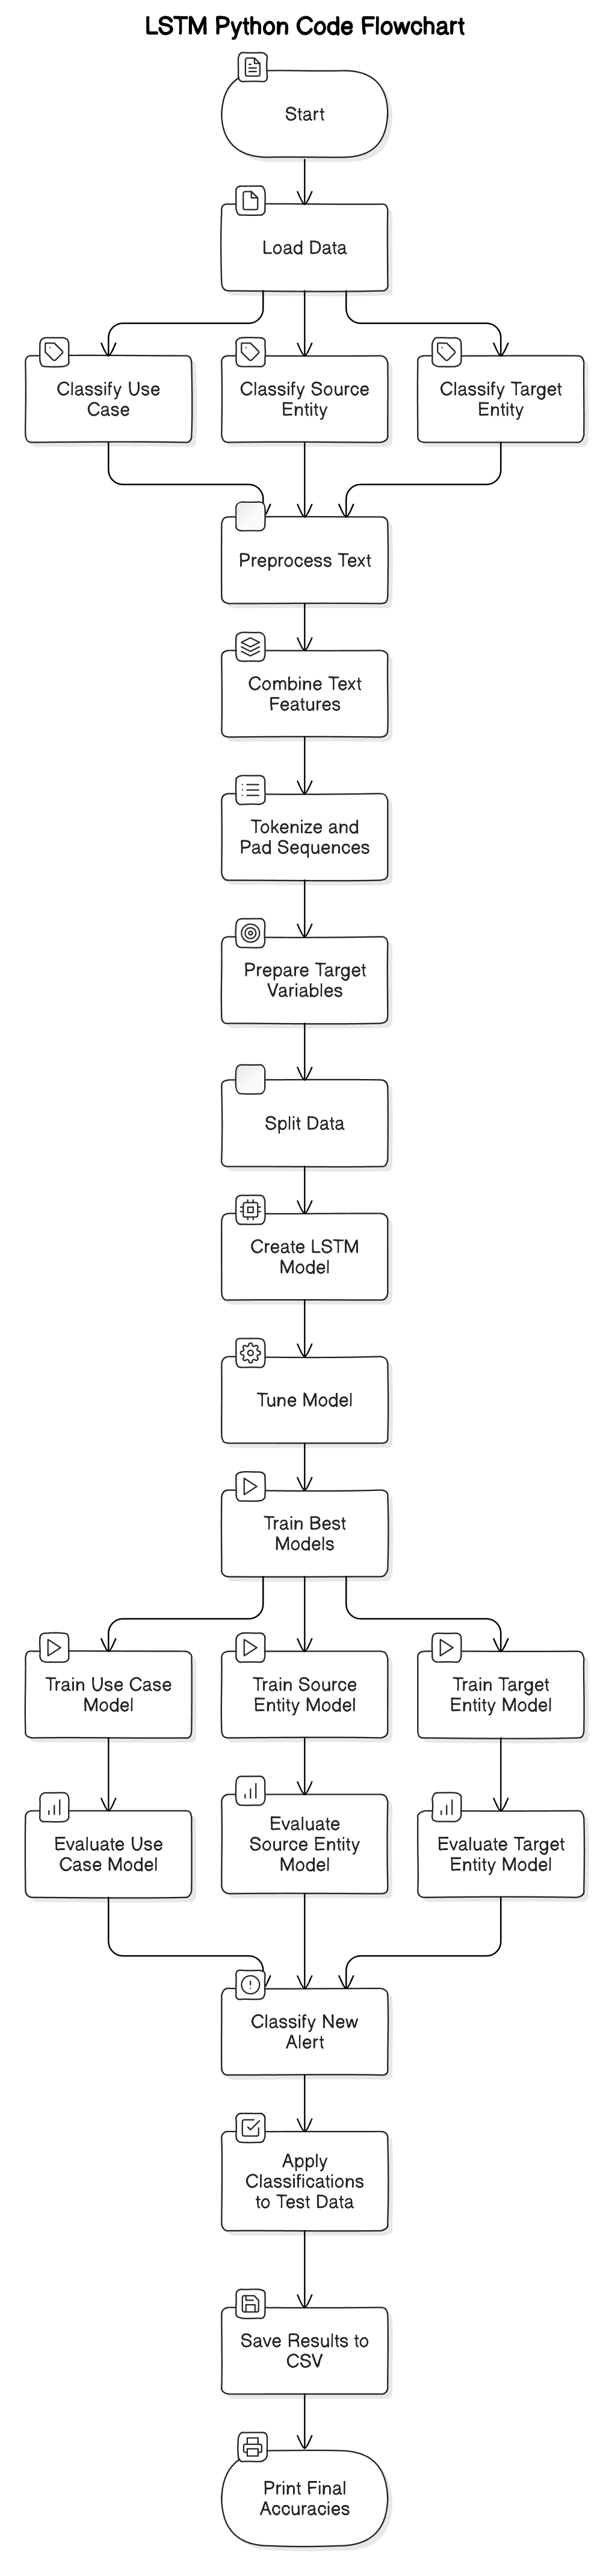

In [10]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.6 MB/s eta 0:00:00


# 1

In [4]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


# **Optim**

In [13]:
# !rm -rf /content/model_tuning

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json
import csv
from collections import defaultdict

# New imports for LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Load the data
df = pd.read_csv('task1.csv').head(2000)
test_df = pd.read_csv('task1.csv').tail(83)

# Function to classify use case
def classify_use_case(row):
    categories = []
    if 'IAM' in row['alert_name'] or 'Role' in row['alert_name'] or 'Policy' in row['alert_name']:
        categories.append('IAM / Entitlement Issues')
    if 'New violations' in row['alert_name'] or 'Compliance' in row['alert_name'] or 'Failed' in row['alert_name']:
        categories.append('Compliance / Hygiene / Security Issues / API failures')
    if 'Vulnerability' in row['alert_name']:
        categories.append('Vulnerability Management')
    if 'Malicious' in row['alert_name'] or 'Threat' in row['alert_name']:
        categories.append('Known Malicious Artifacts')
    if 'Key' in row['alert_name'] or 'Encryption' in row['alert_name']:
        categories.append('Key Management Issues')
    if not categories:
        categories.append('Other')
    return '|'.join(categories)

# Function to classify alert source entity
def classify_source_entity(row):
    if 'process' in row['alert_name'].lower() or 'file' in row['alert_name'].lower():
        return 'application / process / file'
    elif 'S3' in row['alert_name'] or 'storage' in row['alert_name'].lower():
        return 'resource_storage'
    elif pd.notna(row['hostname']) or pd.notna(row['instance_id']):
        return 'host'
    elif pd.notna(row['user_name']) or pd.notna(row['access_key_id']) or 'IAM' in row['alert_name']:
        return 'identity'
    else:
        return 'unknown'

# Function to classify alert target entity
def classify_target_entity(row):
    if 'EC2' in row['alert_name'] or 'instance' in row['alert_name'].lower():
        return 'host'
    elif 'VPC' in row['alert_name'] or 'subnet' in row['alert_name'] or 'network' in row['alert_name'].lower():
        return 'network connection'
    elif 'S3' in row['alert_name'] or 'storage' in row['alert_name'].lower():
        return 'resource_storage'
    elif 'API' in row['alert_name']:
        return 'resource_api'
    elif 'IAM' in row['alert_name'] or 'user' in row['alert_name'].lower() or 'role' in row['alert_name'].lower():
        return 'identity'
    else:
        return 'unknown'

# Apply classifications
df['use_case'] = df.apply(classify_use_case, axis=1)
df['source_entity'] = df.apply(classify_source_entity, axis=1)
df['target_entity'] = df.apply(classify_target_entity, axis=1)

# Preprocess text data
def preprocess_text(text):
    return ' '.join([str(word).lower() for word in text.split()])

# Combine relevant text features
df['text_features'] = df['alert_name'] + ' ' + df['description'] + ' ' + df['alert_type']
df['text_features'] = df['text_features'].apply(preprocess_text)

# Tokenize and pad sequences
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_features'])

sequences = tokenizer.texts_to_sequences(df['text_features'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Prepare target variables
use_case_labels = df['use_case'].str.get_dummies(sep='|').values
source_entity_encoder = LabelEncoder()
target_entity_encoder = LabelEncoder()

source_entity_labels = source_entity_encoder.fit_transform(df['source_entity'])
target_entity_labels = target_entity_encoder.fit_transform(df['target_entity'])

# Split the data
X_train, X_test, y_train_use_case, y_test_use_case, y_train_source, y_test_source, y_train_target, y_test_target = train_test_split(
    padded_sequences, use_case_labels, source_entity_labels, target_entity_labels, test_size=0.2, random_state=42
)

# Modify the create_lstm_model function
def create_lstm_model(hp, input_dim, output_dim, problem_type='multi_label'):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim,
                        output_dim=hp.Int('embedding_dim', min_value=32, max_value=256, step=32),
                        input_length=max_length))

    for i in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32),
                       return_sequences=True if i < hp.Int('num_lstm_layers', 1, 3) - 1 else False))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('final_dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(output_dim, activation='sigmoid' if problem_type == 'multi_label' else 'softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy' if problem_type == 'multi_label' else 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Function to perform hyperparameter tuning
def tune_model(X_train, y_train, input_dim, output_dim, problem_type):
    tuner = RandomSearch(
        lambda hp: create_lstm_model(hp, input_dim, output_dim, problem_type),
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=2,
        directory='model_tuning',
        project_name=f'lstm_{problem_type}'
    )

    tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

# Tune and train models
use_case_model = tune_model(X_train, y_train_use_case, max_words, use_case_labels.shape[1], 'multi_label')
source_entity_model = tune_model(X_train, y_train_source, max_words, len(source_entity_encoder.classes_), 'multi_class')
target_entity_model = tune_model(X_train, y_train_target, max_words, len(target_entity_encoder.classes_), 'multi_class')

# Train the best models
use_case_model.fit(X_train, y_train_use_case, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
source_entity_model.fit(X_train, y_train_source, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
target_entity_model.fit(X_train, y_train_target, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate models
use_case_pred = use_case_model.predict(X_test)
source_entity_pred = source_entity_model.predict(X_test)
target_entity_pred = target_entity_model.predict(X_test)

print("\nClassification Report for Use Case:")
print(classification_report(y_test_use_case, (use_case_pred > 0.5).astype(int), target_names=df['use_case'].str.get_dummies(sep='|').columns, zero_division=1))

print("\nClassification Report for Source Entity:")
print(classification_report(y_test_source, np.argmax(source_entity_pred, axis=1), target_names=source_entity_encoder.classes_, zero_division=1))

print("\nClassification Report for Target Entity:")
print(classification_report(y_test_target, np.argmax(target_entity_pred, axis=1), target_names=target_entity_encoder.classes_, zero_division=1))

# Function to classify new alerts
def classify_new_alert(alert_data):
    alert_text = f"{alert_data['alert_name']} {alert_data['description']} {alert_data['alert_type']}"
    alert_text = preprocess_text(alert_text)
    sequence = tokenizer.texts_to_sequences([alert_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    use_case_prob = use_case_model.predict(padded_sequence)[0]
    source_entity_prob = source_entity_model.predict(padded_sequence)[0]
    target_entity_prob = target_entity_model.predict(padded_sequence)[0]

    use_case_classes = df['use_case'].str.get_dummies(sep='|').columns
    source_entity_classes = source_entity_encoder.classes_
    target_entity_classes = target_entity_encoder.classes_

    use_case = [use_case_classes[i] for i, prob in enumerate(use_case_prob) if prob > 0.5]
    source_entity = source_entity_classes[np.argmax(source_entity_prob)]
    target_entity = target_entity_classes[np.argmax(target_entity_prob)]

    return {
        'use_case': {
            'classification': use_case,
            'probabilities': {k: float(v) for k, v in zip(use_case_classes, use_case_prob)}
        },
        'source_entity': {
            'classification': source_entity,
            'probabilities': {k: float(v) for k, v in zip(source_entity_classes, source_entity_prob)}
        },
        'target_entity': {
            'classification': target_entity,
            'probabilities': {k: float(v) for k, v in zip(target_entity_classes, target_entity_prob)}
        }
    }

# Apply classifications to test_df
test_df['use_case'] = test_df.apply(classify_use_case, axis=1)
test_df['source_entity'] = test_df.apply(classify_source_entity, axis=1)
test_df['target_entity'] = test_df.apply(classify_target_entity, axis=1)

# Use test_df for holdout alerts
holdout_alerts = test_df.to_dict('records')

# Modify the testing loop to work with the new holdout_alerts and save results to CSV
csv_filename = 'holdout_alerts_results.csv'
correct_counts = defaultdict(int)
total_counts = defaultdict(int)

with open(csv_filename, 'w', newline='') as csvfile:
    fieldnames = ['Alert_Number', 'Predicted_Use_Case', 'True_Use_Case', 'Use_Case_Correct',
                  'Predicted_Source_Entity', 'True_Source_Entity', 'Source_Entity_Correct',
                  'Predicted_Target_Entity', 'True_Target_Entity', 'Target_Entity_Correct',
                  'User_Input_JSON']

    # Add new fieldnames for probabilities
    for category in ['Use_Case', 'Source_Entity', 'Target_Entity']:
        if category == 'Use_Case':
            for use_case in df['use_case'].str.get_dummies(sep='|').columns:
                fieldnames.append(f'{category}_Prob_{use_case}')
        else:
            for entity in (source_entity_encoder.classes_ if category == 'Source_Entity' else target_entity_encoder.classes_):
                fieldnames.append(f'{category}_Prob_{entity}')

    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for i, alert in enumerate(holdout_alerts, 1):
        classification = classify_new_alert(alert)

        predicted_use_cases = set(classification['use_case']['classification'])
        true_use_cases = set(alert['use_case'].split('|'))

        use_case_correct = predicted_use_cases == true_use_cases
        source_entity_correct = classification['source_entity']['classification'] == alert['source_entity']
        target_entity_correct = classification['target_entity']['classification'] == alert['target_entity']

        correct_counts['Use_Case'] += int(use_case_correct)
        correct_counts['Source_Entity'] += int(source_entity_correct)
        correct_counts['Target_Entity'] += int(target_entity_correct)
        total_counts['Use_Case'] += 1
        total_counts['Source_Entity'] += 1
        total_counts['Target_Entity'] += 1

        # Create a JSON string of the user input (alert data)
        user_input_json = json.dumps({
            'alert_name': alert['alert_name'],
            'description': alert['description'],
            'alert_type': alert['alert_type'],
            'hostname': alert['hostname'],
            'instance_id': alert['instance_id'],
            'user_name': alert['user_name'],
            'access_key_id': alert['access_key_id']
        })

        row_data = {
            'Alert_Number': i,
            'Predicted_Use_Case': '|'.join(predicted_use_cases),
            'True_Use_Case': alert['use_case'],
            'Use_Case_Correct': use_case_correct,
            'Predicted_Source_Entity': classification['source_entity']['classification'],
            'True_Source_Entity': alert['source_entity'],
            'Source_Entity_Correct': source_entity_correct,
            'Predicted_Target_Entity': classification['target_entity']['classification'],
            'True_Target_Entity': alert['target_entity'],
            'Target_Entity_Correct': target_entity_correct,
            'User_Input_JSON': user_input_json
        }

        # Add probabilities to row_data
        for category, prob_dict in classification.items():
            for class_name, prob in prob_dict['probabilities'].items():
                row_data[f'{category.title()}_Prob_{class_name}'] = prob

        writer.writerow(row_data)

print(f"Results have been saved to {csv_filename}")

# Print final accuracies
print("\nFinal Accuracies:")
for task in ['Use_Case', 'Source_Entity', 'Target_Entity']:
    accuracy = correct_counts[task] / total_counts[task] * 100
    print(f"{task}: {accuracy:.2f}%")


Trial 5 Complete [00h 00m 27s]
val_accuracy: 0.856249988079071

Best val_accuracy So Far: 0.9140625
Total elapsed time: 00h 02m 28s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Reloading Tuner from model_tuning/lstm_multi_class/tuner0.json
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6920 - loss: 0.3964 - val_accuracy: 0.6875 - val_loss: 0.3967
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6869 - loss: 0.4016 - val_accuracy: 0.6875 - val_loss: 0.3972
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6985 - loss: 0.3995 - val_accuracy: 0.6875 - val_loss: 0.3958
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7012 - loss: 0.3917 - val_accuracy: 0.6875 - val_loss: 0.3951
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7245 - loss: 0.3756 - val_accuracy: 0.6875 - val_loss: 0.3946
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6947 - loss: 0.3982 - val_accuracy: 0.6875 - val_loss: 0.3971
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6961 - loss: 0.3995 - val_accuracy: 0.6875 - val_loss: 0.3960
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/st

# Report

In [ ]:
#Final Accuracies Base Model: +/-
Use_Case: 68.67%
Source_Entity: 83.13%
Target_Entity: 71.08%

In [ ]:
#Final Accuracies After Optim: +/-
Use_Case: 68.67%
Source_Entity: 97.59%
Target_Entity: 72.29%